In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import os
import numpy as np
import time
import random
sns.set_theme(style="whitegrid", palette="Set2")

# Preprocessing

In [2]:
results = {
    'Logistic Regression': {
        'Resizing train': 96.58,
        'Resizing valid': 87.98,
        'Padding train': 97.2,
        'Padding valid': 90.13,
        'Center cropping train': 94.24,
        'Center cropping valid': 85.11,
    },
    'CNN 2 layers': {
        'Resizing train': 96.89,
        'Resizing valid': 93.58,
        'Padding train': 95.83,
        'Padding valid': 93.99,
        'Center cropping train': 97.3,
        'Center cropping valid': 91.39,
    },
    'CNN 5 layers': {
        'Resizing train': 92.45,
        'Resizing valid': 93.17,
        'Padding train': 94.88,
        'Padding valid': 93.44,
        'Center cropping train': 92.69,
        'Center cropping valid': 93.44,
    },
    'DenseNet-121': {
        'Resizing train': 95.63,
        'Resizing valid': 95.49,
        'Padding train': 95.39,
        'Padding valid': 94.81,
        'Center cropping train': 95.63,
        'Center cropping valid': 94.4,
    },
    'DenseNet-201': {
        'Resizing train': 96.93,
        'Resizing valid': 95.08,
        'Padding train': 96.69,
        'Padding valid': 95.22,
        'Center cropping train': 94.88,
        'Center cropping valid': 94.53,
    },
}

In [3]:
df = pd.DataFrame(results).reset_index()
df

,index,Logistic Regression,CNN 2 layers,CNN 5 layers,DenseNet-121,DenseNet-201
0,Resizing train,96.58,96.89,92.45,95.63,96.93
1,Resizing valid,87.98,93.58,93.17,95.49,95.08
2,Padding train,97.20,95.83,94.88,95.39,96.69
3,Padding valid,90.13,93.99,93.44,94.81,95.22
4,Center cropping train,94.24,97.30,92.69,95.63,94.88
5,Center cropping valid,85.11,91.39,93.44,94.40,94.53


In [4]:
df = pd.DataFrame(results).reset_index()
df = pd.melt(df, id_vars=['index'], 
        value_vars=['Logistic Regression', 'CNN 2 layers', 'CNN 5 layers', 'DenseNet-121', 'DenseNet-201'],
        var_name='Model', value_name='Accuracy')

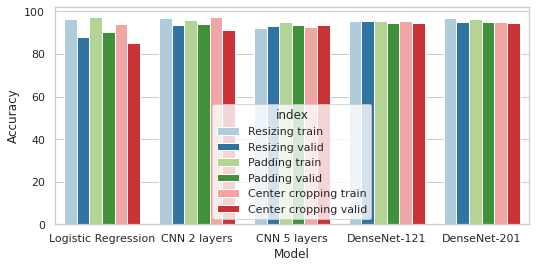

In [5]:
sns.set_theme(style="whitegrid", palette="Paired")
plt.figure(figsize=(8.5,4))
ax = sns.barplot(data=df, x='Model', y='Accuracy', hue='index')
sns.move_legend(ax, "lower center")
#plt.xticks(rotation=90);

# Models

In [6]:
import glob
os.chdir('/kaggle/input/run-histories')
histories = glob.glob("*.*")

In [7]:
col_names = ['loss', 'accuracy', 'precision', 'recall', 'auc', 
'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 
'val_auc', 'model_name']

df = pd.read_csv(histories[0])
col_dict = {x: y for x, y in zip(df.columns, col_names)}
df = df.rename(columns=col_dict)
df['epoch'] = pd.Series(range(len(df))) + 1
for path in histories:
    df_temp = pd.read_csv(path)
    model_name = path.split('.')[0]
    if "Unnamed: 0" in df_temp.columns:
        df_temp = df_temp.drop(columns=["Unnamed: 0"])
    df_temp["model_name"] = pd.Series([model_name]*len(df_temp))
    col_dict = {x: y for x, y in zip(df_temp.columns, col_names)}
    df_temp = df_temp.rename(columns=col_dict)
    df_temp['epoch'] = pd.Series(range(len(df_temp))) + 1
    df = df.append(df_temp)

In [8]:
df['model'] = df.model_name.apply(lambda x: x.split("_")[0])
df['dataset'] = df.model_name.apply(lambda x: x.split("_")[1])
df = df.reset_index()

<AxesSubplot:xlabel='epoch', ylabel='Value'>

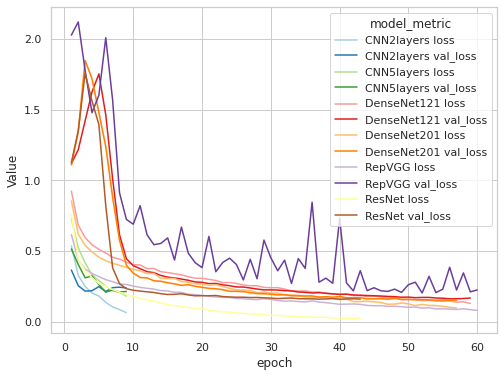

In [9]:
sns.set_theme(style="whitegrid", palette="Paired")

def df_history(df, dataset, metric, models):
    df = df[df.dataset==dataset]
    df = df[df.model.isin(models)]
    
    df = pd.melt(df, id_vars=['epoch', 'model'], value_vars=[metric, 'val_'+ metric],
        var_name='metric', value_name='Value')
    df['model_metric'] = df.model + " " + df.metric
    df = df.sort_values(by=['model_metric'])
    return df

models = ['CNN2layers', 'CNN5layers', 'DenseNet121', 'DenseNet201', 'ResNet', 'RepVGG']
a = df_history(df, 'padded', 'loss', models)
plt.figure(figsize=(8,6))
sns.lineplot(data=a, x='epoch', y='Value', hue='model_metric')

<AxesSubplot:xlabel='epoch', ylabel='Value'>

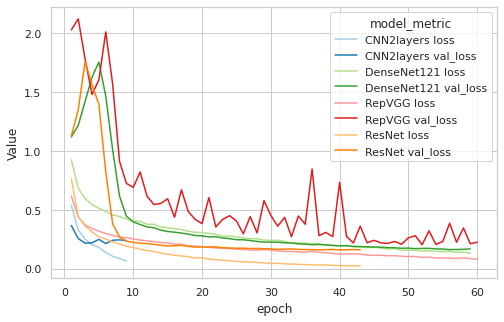

In [10]:
models = ['CNN2layers', 'DenseNet121', 'ResNet', 'RepVGG']
a = df_history(df, 'padded', 'loss', models)
plt.figure(figsize=(8,5))
sns.lineplot(data=a, x='epoch', y='Value', hue='model_metric')

<AxesSubplot:xlabel='epoch', ylabel='Value'>

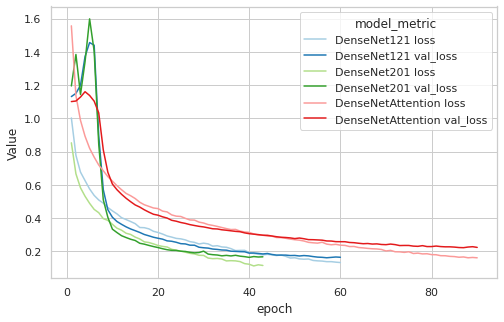

In [11]:
models = ['DenseNet121', 'DenseNet201', 'DenseNetAttention']
a = df_history(df, 'resized', 'loss', models)
plt.figure(figsize=(8,5))
sns.lineplot(data=a, x='epoch', y='Value', hue='model_metric')

<AxesSubplot:xlabel='epoch', ylabel='Value'>

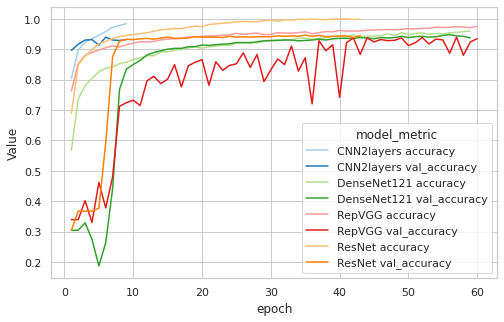

In [12]:
models = ['CNN2layers', 'DenseNet121', 'ResNet', 'RepVGG']
a = df_history(df, 'padded', 'accuracy', models)
plt.figure(figsize=(8,5))
sns.lineplot(data=a, x='epoch', y='Value', hue='model_metric')

In [13]:
# train and test accuracies for all the methods
idx = df.groupby(['model_name'])['val_accuracy'].transform(max) == df['val_accuracy']
df_max = df[idx]
df_max = df_max.drop_duplicates(subset=['model', 'dataset', 'val_accuracy'], keep='first')
df_max = pd.melt(df_max, id_vars=['model', 'dataset'], 
                 value_vars=['accuracy', 'val_accuracy'],                 
                 var_name='metric', value_name='Value')
df_max['Dataset and metric'] = df_max.dataset + " " + df_max.metric
df_max = df_max.sort_values(by=['model', 'Dataset and metric'])

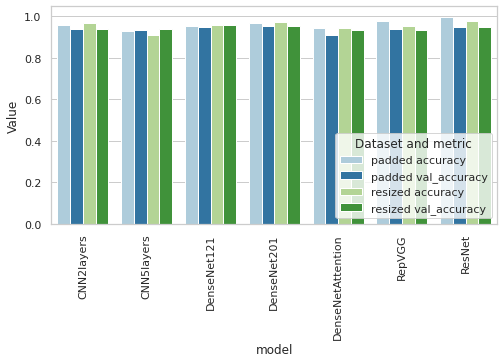

In [14]:
plt.figure(figsize=(8,4))
ax = sns.barplot(data=df_max[df_max.dataset!='aug'], x='model', y='Value', hue='Dataset and metric')
sns.move_legend(ax, 'lower right')
plt.xticks(rotation=90);

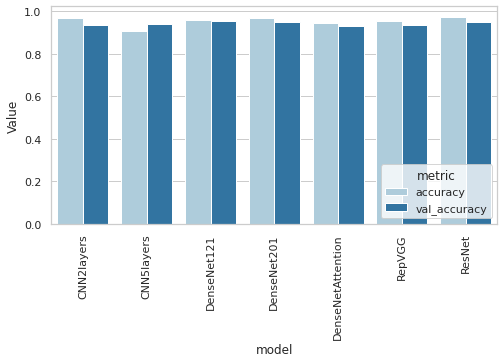

In [15]:
plt.figure(figsize=(8,4))
ax = sns.barplot(data=df_max[df_max.dataset=='resized'], x='model', y='Value', hue='metric')
sns.move_legend(ax, 'lower right')
plt.xticks(rotation=90);

In [16]:
df_aug = df_max[(df_max.model == "CNN2layers") | (df_max.model == "DenseNet121")]
df_aug = df_aug[df_aug.dataset != 'resized']
df_aug

,model,dataset,metric,Value,Dataset and metric
7,CNN2layers,aug,accuracy,0.789959,aug accuracy
23,CNN2layers,aug,val_accuracy,0.848361,aug val_accuracy
3,CNN2layers,padded,accuracy,0.958333,padded accuracy
19,CNN2layers,padded,val_accuracy,0.939891,padded val_accuracy
13,DenseNet121,aug,accuracy,0.866462,aug accuracy
29,DenseNet121,aug,val_accuracy,0.894809,aug val_accuracy
12,DenseNet121,padded,accuracy,0.953893,padded accuracy
28,DenseNet121,padded,val_accuracy,0.948087,padded val_accuracy


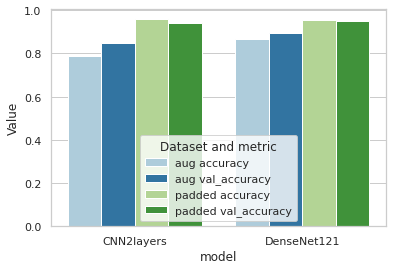

In [17]:
sns.set_theme(style="whitegrid", palette="Paired")

plt.figure(figsize=(6,4))
ax = sns.barplot(data=df_aug, x='model', y='Value', hue='Dataset and metric')
sns.move_legend(ax, "lower center")